In [1]:
cd("/g/data/v45/nc3020/Oceananigans-Tutorial-CFP/")

ENV["JULIA_DEPOT_PATH"] = "/g/data/v45/nc3020/.julia:/share/julia/site/"
ENV["JULIA_LOAD_PATH"] = "@:@v#.#:@stdlib:@site"
ENV["JULIA_CUDA_USE_BINARYBUILDER"] = "false"

using Pkg; Pkg.activate(@__DIR__);

  Activating project at `/g/data/v45/nc3020/Oceananigans-Tutorial-CFP`


In [2]:
using Oceananigans
using Oceananigans.Units

using CUDA

┌ Error: JULIA_CUDA_USE_BINARYBUILDER is deprecated, and CUDA.jl always uses artifacts now.
│ To use a local installation, use overrides or preferences to customize the artifact.
│ Please check the CUDA.jl or Pkg.jl documentation for more details.
└ @ CUDA /g/data/v45/nc3020/.julia/packages/CUDA/s0e3j/src/initialization.jl:146
[ Info: Oceananigans will use 12 threads


In [320]:
Nx, Nz = 600, 160

architecture = GPU()

H  = 2kilometers
Lx = 1600kilometers

underlying_grid = RectilinearGrid(architecture,
                                  size = (Nx, Nz),
                                  x = (-Lx/2, Lx/2),
                                  z = (-H, 0),
                                  halo = (4, 4), # start with this commented out
                                  topology = (Periodic, Flat, Bounded))

600×1×160 RectilinearGrid{Float64, Periodic, Flat, Bounded} on GPU with 4×0×4 halo
├── Periodic x ∈ [-800000.0, 800000.0) regularly spaced with Δx=2666.67
├── Flat y
└── Bounded  z ∈ [-2000.0, 0.0]        regularly spaced with Δz=12.5

Now we want to create a bathymetry as an immersed boundary grid.

$$
h(x) = -H + h_0 \, \exp(-x^2 / 2\sigma^2)
$$

In [327]:
h₀ = 50 # m
width = 5kilometers
bump(x, y) = - H + h₀ * exp(-x^2 / 2width^2)

grid = ImmersedBoundaryGrid(underlying_grid, GridFittedBottom(bump))

600×1×160 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on GPU with 4×0×4 halo:
├── immersed_boundary: GridFittedBottom(min(h)=-2.00e+03, max(h)=-1.95e+03)
├── underlying_grid: 600×1×160 RectilinearGrid{Float64, Periodic, Flat, Bounded} on GPU with 4×0×4 halo
├── Periodic x ∈ [-800000.0, 800000.0) regularly spaced with Δx=2666.67
├── Flat y
└── Bounded  z ∈ [-2000.0, 0.0]        regularly spaced with Δz=12.5

In [328]:
xC = xnodes(grid, Center())

bottom = CUDA.@allowscalar collect(grid.immersed_boundary.bottom_height[1:Nx, 1]);

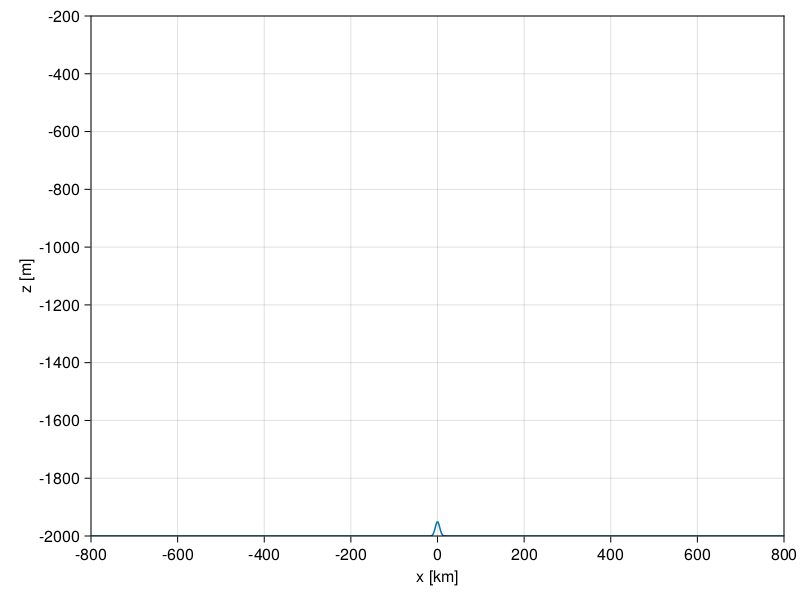

In [329]:
using CairoMakie

fig = Figure()
ax = Axis(fig[1, 1],
          xlabel="x [km]",
          ylabel="z [m]",
          limits=((-Lx/2e3, Lx/2e3), (-H, -H/10)))

lines!(ax, xC/1e3, bottom)

fig

The $M_2$ tidal forcing. We add forcing in the $u$-momentum equation of the form:

$$
\partial_t u = \dots + f_0 \cos(\omega_2 t)
$$

In [330]:
T₂ = 12.421hours
const ω₂ = 2π / T₂ # radians/sec

0.00014051439111137024

The excursion parameter is a nondimensional number denoting how much movement the tidal flow imposes compared with the width of the hill.

$$
\varepsilon = \frac{U}{ω \, σ}
$$

In [331]:
ε = 0.2
U_tidal = ε * ω₂ * width

coriolis = FPlane(latitude = -45)

const tidal_forcing_amplitude = U_tidal * (coriolis.f^2 - ω₂^2) / ω₂

@inline tidal_forcing(x, y, z, t) = tidal_forcing_amplitude * cos(ω₂ * t)

tidal_forcing (generic function with 1 method)

In [348]:
gravitational_acceleration = 9.81
gravity_wave_speed = sqrt(gravitational_acceleration * grid.Lz)
gravity_wave_timescale = 0.2 * minimum_xspacing(grid) / gravity_wave_speed

tidal_timescale = 1 / ω₂

Δt = 0.01 * tidal_timescale

@show prettytime(Δt)

prettytime(Δt) = "1.186 minutes"


"1.186 minutes"

In [349]:
using Oceananigans.Models.HydrostaticFreeSurfaceModels: FFTImplicitFreeSurfaceSolver

fft_preconditioner = FFTImplicitFreeSurfaceSolver(grid)
free_surface = ImplicitFreeSurface(solver_method=:PreconditionedConjugateGradient, preconditioner=fft_preconditioner);

In [350]:
closure = HorizontalScalarDiffusivity(ν=1e2, κ=1e2)

HorizontalScalarDiffusivity{ExplicitTimeDiscretization}(ν=100.0, κ=100.0)

In [351]:
model = HydrostaticFreeSurfaceModel(grid = grid,
                                    free_surface = free_surface,
                                    coriolis = coriolis,
                                    buoyancy = BuoyancyTracer(),
                                    tracers = :b,
                                    momentum_advection = WENO(),
                                    tracer_advection = WENO(),
                                    # closure = closure,
                                    forcing = (u = tidal_forcing,))

HydrostaticFreeSurfaceModel{GPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── grid: 600×1×160 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on GPU with 4×0×4 halo
├── timestepper: QuasiAdamsBashforth2TimeStepper
├── tracers: b
├── closure: Nothing
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
├── free surface: ImplicitFreeSurface with gravitational acceleration 9.80665 m s⁻²
│   └── solver: PCGImplicitFreeSurfaceSolver
└── coriolis: FPlane{Float64}

In [352]:
stop_time = 12T₂

simulation = Simulation(model, Δt=Δt, stop_time=stop_time)

Simulation of HydrostaticFreeSurfaceModel{GPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 1.186 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 6.210 days
├── Stop iteration : Inf
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [353]:
using Printf

wall_clock = Ref(time_ns())

function print_progress(sim)

    elapsed = 1e-9 * (time_ns() - wall_clock[])

    msg = @sprintf("iteration: %d, time: %s, wall time: %s, max|w|: %6.3e, m s⁻¹, next Δt: %s\n",
                   iteration(sim), prettytime(sim), prettytime(elapsed),
                   maximum(abs, sim.model.velocities.w), prettytime(sim.Δt))

    wall_clock[] = time_ns()

    @info msg

    return nothing
end

simulation.callbacks[:print_progress] = Callback(print_progress, IterationInterval(200))

Callback of print_progress on IterationInterval(200)

## Diagnostics

There are no predefine diagnostics in Oceananigans! Instead users are expected to construct their own using normal algebraic operations and calculus!

Each model has velocities and some tracers, like buoyancy $b$ or temperature and salinity ($T$ and $S$).

Let's create a few!

In [354]:
b = model.tracers.b
u, v, w = model.velocities

NamedTuple with 3 Fields on 600×1×160 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on GPU with 4×0×4 halo:
├── u: 600×1×160 Field{Face, Center, Center} on ImmersedBoundaryGrid on GPU
├── v: 600×1×160 Field{Center, Face, Center} on ImmersedBoundaryGrid on GPU
└── w: 600×1×161 Field{Center, Center, Face} on ImmersedBoundaryGrid on GPU

In [355]:
U = Field(Average(u))

u′ = u - U

BinaryOperation at (Face, Center, Center)
├── grid: 600×1×160 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on GPU with 4×0×4 halo
└── tree: 
    - at (Face, Center, Center)
    ├── 600×1×160 Field{Face, Center, Center} on ImmersedBoundaryGrid on GPU
    └── 1×1×1 Field{Nothing, Nothing, Nothing} reduced over dims = (1, 2, 3) on ImmersedBoundaryGrid on GPU

The buoyancy frequency $N^2 = \partial_z b$:

In [356]:
N² = ∂z(b)

Derivative at (Center, Center, Face)
├── grid: 600×1×160 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on GPU with 4×0×4 halo
└── tree: 
    ∂zᶜᶜᶠ at (Center, Center, Face) via identity
    └── 600×1×160 Field{Center, Center, Center} on ImmersedBoundaryGrid on GPU

The velocity vertical shear squared, $S^2 = (\partial_z u)^2 + (\partial_z v)^2$:

In [357]:
S² = @at (Center, Center, Face) ∂z(u)^2 + ∂z(v)^2

BinaryOperation at (Center, Center, Face)
├── grid: 600×1×160 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on GPU with 4×0×4 halo
└── tree: 
    + at (Center, Center, Face)
    ├── ^ at (Center, Center, Face)
    │   ├── ∂zᶠᶜᶠ at (Center, Center, Face) via ℑxᶜᵃᵃ
    │   │   └── 600×1×160 Field{Face, Center, Center} on ImmersedBoundaryGrid on GPU
    │   └── 2
    └── ^ at (Center, Center, Face)
        ├── ∂zᶜᶠᶠ at (Center, Center, Face) via ℑyᵃᶜᵃ
        │   └── 600×1×160 Field{Center, Face, Center} on ImmersedBoundaryGrid on GPU
        └── 2

And the Richardson number, $Ri = N^2 / S^2$.

In [358]:
Ri = N² / S²

BinaryOperation at (Center, Center, Face)
├── grid: 600×1×160 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on GPU with 4×0×4 halo
└── tree: 
    / at (Center, Center, Face)
    ├── ∂zᶜᶜᶠ at (Center, Center, Face) via identity
    │   └── 600×1×160 Field{Center, Center, Center} on ImmersedBoundaryGrid on GPU
    └── + at (Center, Center, Face)
        ├── ^ at (Center, Center, Face)
        │   ├── ∂zᶠᶜᶠ at (Center, Center, Face) via ℑxᶜᵃᵃ
        │   │   └── 600×1×160 Field{Face, Center, Center} on ImmersedBoundaryGrid on GPU
        │   └── 2
        └── ^ at (Center, Center, Face)
            ├── ∂zᶜᶠᶠ at (Center, Center, Face) via ℑyᵃᶜᵃ
            │   └── 600×1×160 Field{Center, Face, Center} on ImmersedBoundaryGrid on GPU
            └── 2

In [359]:
name = "barotropic_tide"

simulation.output_writers[:fields] = JLD2OutputWriter(model, (; Ri, N², u′, u, w, b),
                                                      schedule = TimeInterval(15minutes),
                                                      with_halos = false,
                                                      filename = name,
                                                      overwrite_existing = true)

JLD2OutputWriter scheduled on TimeInterval(15 minutes):
├── filepath: ./barotropic_tide.jld2
├── 6 outputs: (Ri, N², u′, u, w, b)
├── array type: Array{Float64}
├── including: [:grid, :coriolis, :buoyancy, :closure]
└── max filesize: Inf YiB

## Initial conditions

In [360]:
# Initial conditions
uᵢ(x, y, z) = U_tidal

Nᵢ² = 4e-5  # [s⁻²] initial buoyancy frequency / stratification
bᵢ(x, y, z) = Nᵢ² * z

set!(model, u=uᵢ, b=bᵢ)

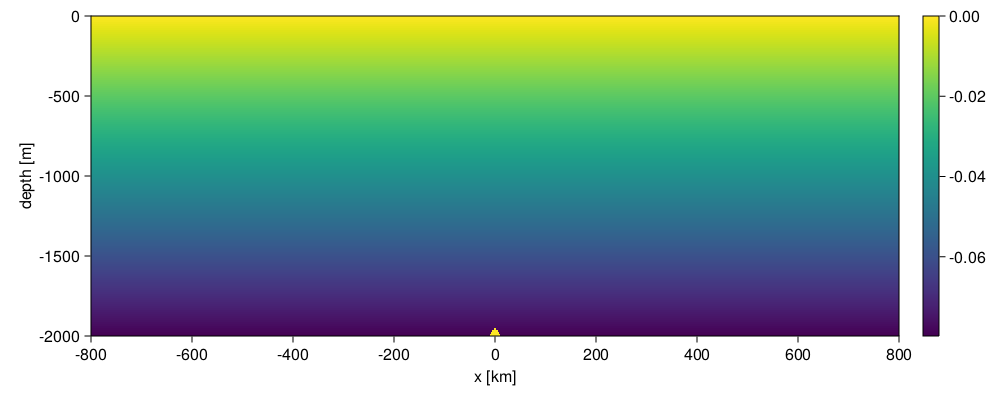

In [361]:
fig = Figure(resolution = (1000, 400))

ax = Axis(fig[1, 1],
          xlabel = "x [km]",
          ylabel = "depth [m]")

x, y, z = nodes(b)

hm = heatmap!(ax, x/1e3, z, collect(interior(b, :, 1, :)))
Colorbar(fig[1, 2], hm)

fig

In [362]:
run!(simulation)

[ Info: Initializing simulation...
[ Info: iteration: 0, time: 0 seconds, wall time: 3.317 seconds, max|w|: 6.587e-04, m s⁻¹, next Δt: 1.186 minutes
[ Info:     ... simulation initialization complete (132.925 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (12.922 ms).
[ Info: iteration: 200, time: 3.849 hours, wall time: 2.159 seconds, max|w|: 2.695e-04, m s⁻¹, next Δt: 1.186 minutes
[ Info: iteration: 400, time: 7.698 hours, wall time: 2.117 seconds, max|w|: 2.698e-04, m s⁻¹, next Δt: 1.186 minutes
[ Info: iteration: 600, time: 11.540 hours, wall time: 2.946 seconds, max|w|: 4.748e-04, m s⁻¹, next Δt: 1.186 minutes
[ Info: iteration: 800, time: 15.388 hours, wall time: 2.046 seconds, max|w|: 6.865e-04, m s⁻¹, next Δt: 1.186 minutes
[ Info: iteration: 1000, time: 19.237 hours, wall time: 2.175 seconds, max|w|: 9.923e-04, m s⁻¹, next Δt: 1.186 minutes
[ Info: iteration: 1200, time: 23.079 hours, wall time: 2.129 seconds, max|w|: 8.930e-04, m s⁻¹, n

In [363]:
saved_output_filename = name * ".jld2"

u_t  = FieldTimeSeries(saved_output_filename, "u")
u′_t = FieldTimeSeries(saved_output_filename, "u′")
w_t  = FieldTimeSeries(saved_output_filename, "w")
N²_t = FieldTimeSeries(saved_output_filename, "N²")

times = u_t.times

597-element Vector{Float64}:
      0.0
    900.0
   1800.0
   2700.0
   3600.0
   4500.0
   5400.0
   6300.0
   7200.0
   8100.0
   9000.0
   9900.0
  10800.0
      ⋮
 526500.0
 527400.0
 528300.0
 529200.0
 530100.0
 531000.0
 531900.0
 532800.0
 533700.0
 534600.0
 535500.0
 536400.0

In [364]:
xu,  yu,  zu  = nodes(u_t[1])
xw,  yw,  zw  = nodes(w_t[1])
xN², yN², zN² = nodes(N²_t[1])

([-798666.6666666666, -796000.0, -793333.3333333334, -790666.6666666666, -788000.0, -785333.3333333334, -782666.6666666666, -780000.0, -777333.3333333334, -774666.6666666666  …  774666.6666666666, 777333.3333333334, 780000.0, 782666.6666666666, 785333.3333333334, 788000.0, 790666.6666666666, 793333.3333333334, 796000.0, 798666.6666666666], StepRangeLen(1.0, 0.0, 1), [-2000.0, -1987.5, -1975.0, -1962.5, -1950.0, -1937.5, -1925.0, -1912.5, -1900.0, -1887.5  …  -112.5, -100.0, -87.5, -75.0, -62.5, -50.0, -37.5, -25.0, -12.5, 0.0])

In [365]:
using Oceananigans.ImmersedBoundaries: mask_immersed_field!

function mask_and_get_interior(φ_t, n)
    mask_immersed_field!(φ_t[n], NaN)
    return interior(φ_t[n], :, 1, :)
end

mask_and_get_interior (generic function with 1 method)

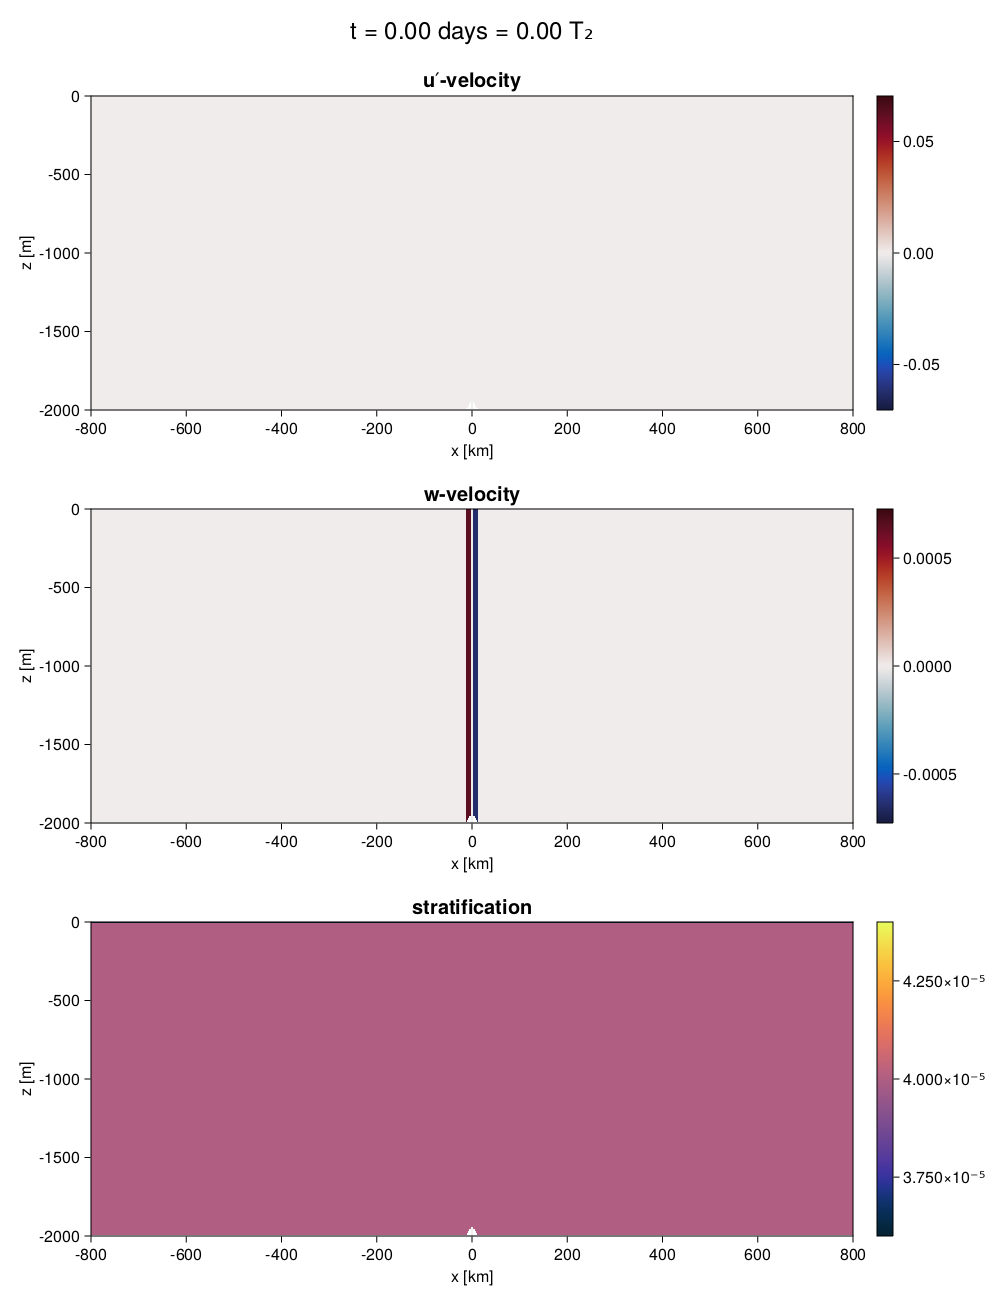

In [366]:
n = Observable(1)

title = @lift @sprintf("t = %1.2f days = %1.2f T₂", round(times[$n]/day, digits=2) , round(times[$n]/T₂, digits=2))

u′ₙ = @lift mask_and_get_interior(u′_t, $n)
wₙ  = @lift mask_and_get_interior(w_t, $n)
N²ₙ = @lift mask_and_get_interior(N²_t, $n)

axis_kwargs = (xlabel = "x [km]",
               ylabel = "z [m]",
               limits = ((-Lx/2e3, Lx/2e3), (-H, 0)),
               titlesize = 20)

ulim   = 0.5 * maximum(abs, u_t[end])
wlim   = maximum(abs, w_t[end])

fig = Figure(resolution = (1000, 1300))

ax_u = Axis(fig[2, 1];
            title = "u′-velocity", axis_kwargs...)

ax_w = Axis(fig[3, 1];
            title = "w-velocity", axis_kwargs...)

ax_N² = Axis(fig[4, 1];
             title = "stratification", axis_kwargs...)

fig[1, :] = Label(fig, title, fontsize=24, tellwidth=false)

hm_u = heatmap!(ax_u, xu/1e3, zu, u′ₙ;
                colorrange = (-ulim, ulim),
                colormap = :balance)
Colorbar(fig[2, 2], hm_u)

hm_w = heatmap!(ax_w, xw/1e3, zw, wₙ;
                colorrange = (-wlim, wlim),
                colormap = :balance)
Colorbar(fig[3, 2], hm_w)

hm_N² = heatmap!(ax_N², xN²/1e3, zN², N²ₙ;
                 colorrange = (0.9Nᵢ², 1.1Nᵢ²),
                 colormap = :thermal)
Colorbar(fig[4, 2], hm_N²)

fig

In [367]:
@info "Making an animation from saved data..."

frames = 1:length(times)

CairoMakie.record(fig, name * ".mp4", frames, framerate=24) do i
    msg = string("Plotting frame ", i, " of ", frames[end])
    print(msg * " \r")
    n[] = i
end

[ Info: Making an animation from saved data...


"barotropic_tide.mp4"

![](barotropic_tide.mp4)